## Post-processing of ampcor dense offset from `topsApp.py`

+ `topsApp.xml`

```xml
<topsApp>
  <component name="topsinsar">
    ...
    <property name="swaths">[1,2,3]</property>
    <property name="region of interest">[35.5, 39.0, 35.5, 39.0]</property>
    <property name="do ESD">True</property>

    <!-- Dense Offsets -->
    <property name="do dense offsets">True</property>
    <property name="ampcor window width">128</property>
    <property name="ampcor window height">64</property>
    <property name="ampcor skip width">64</property>
    <property name="ampcor skip height">32</property>
    <property name="ampcor oversampling factor">32</property>
    <property name="ampcor search window width">20</property>
    <property name="ampcor search window height">20</property>
    <property name="ampcor margin">50</property>
    <property name="filter window size">5</property>
    ...
  </component>
</topsApp>
```

In [18]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, view
from mintpy.view import prep_slice, plot_slice
plt.rcParams.update({'font.size': 12})

# dataset
proj_dir = os.path.expanduser('~/data/archives/2023TurkeyEQ')
ds_name = [
    'S1_A014_20230128_20230209_RG',
    'S1_A014_20230128_20230209_AZ',
    'S1_D021_20230129_20230210_RG',
    'S1_D021_20230129_20230210_AZ',
][2]
redo = True

work_dir = os.path.join(proj_dir, ds_name[:-3], 'offset_v5')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# grid
S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1;  36.0, 39.0, 35.8, 38.8
step = 0.00277778   # deg (~300 m)  # set to None to calculate product resolution for reference

# input files
off_file = os.path.join(work_dir, 'filt_dense_offsets.bil')
cov_file = os.path.join(work_dir, 'dense_offsets_cov.bil')
snr_file = os.path.join(work_dir, 'dense_offsets_snr.bil')
lat_file = os.path.join(work_dir, 'lat.rdr.mli')
lon_file = os.path.join(work_dir, 'lon.rdr.mli')
los_file = os.path.join(work_dir, 'los.rdr.mli')
hgt_file = os.path.join(work_dir, 'z.rdr.mli')
msk_file = os.path.join(work_dir, 'waterMask.h5')
xml_file = os.path.join(work_dir, '../referencedir/IW1.xml')
atr = readfile.read_attribute(off_file)

# output files
rdr_file = os.path.join(work_dir, 'offRg.h5' if ds_name.endswith('RG') else 'offAz.h5')

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5


In [20]:
# utils functions
def read_offset():
    # calculate pixel_size (to convert offset unit from pixel to meters)
    meta = isce_utils.extract_isce_metadata(xml_file, update_mode=False)[0]

    obs_dir = 'range' if ds_name.endswith('RG') else 'azimuth'
    if obs_dir == 'range':
        pixel_size = float(meta['RANGE_PIXEL_SIZE'])
        print('Slant range pixel size: {:.2f} m'.format(pixel_size))
    else:
        Re, h_sat = float(meta['EARTH_RADIUS']), float(meta['HEIGHT'])
        pixel_size = float(meta['AZIMUTH_PIXEL_SIZE']) * Re / (Re + h_sat)
        print('Ground azimuth pixel size: {:.2f} m'.format(pixel_size))

    # read data / attribute
    off = readfile.read(off_file, datasetName=f'{obs_dir}Offset')[0] * pixel_size
    off_std = np.sqrt(readfile.read(cov_file, datasetName=f'{obs_dir}OffsetStd')[0]) * pixel_size
    off_snr = readfile.read(snr_file)[0]

    return off, off_std, off_snr


def mask_offset(off, off_std, off_snr, config):
    # 1. ignore no-data-value
    no_data_value = readfile.get_no_data_value(off_file)
    off[off == no_data_value] = np.nan
    print(f'# of pixels after removing no-data-value ({no_data_value}): {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 2. ignore water body
    water_mask = readfile.read(msk_file)[0]
    off[water_mask == 0] = np.nan
    off_std[water_mask == 0] = np.nan
    off_snr[water_mask == 0] = np.nan
    print(f'# of pixels after removing water body: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')
    off_raw = np.array(off, dtype=np.float32)

    # 3. remove pixels with abnormal offset
    off_std[np.isnan(off)] = np.nan
    off[np.abs(off) > config['max_off']] = np.nan
    print(f'# of pixels after removing offset > {config["max_off"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 4. remove pixels with low offset SNR
    off[np.isnan(off_snr)] = np.nan
    flag = off_snr < config['min_snr']    # remove pixels with low SNR value
    flag[np.abs(off / off_std) > 3] = 0   # keep   pixels with high off / off_std
    flag[off_snr < 1] = 1                 # remove pixels with very low SNR value
    off[flag] = np.nan
    print(f'# of pixels after removing SNR < {config["min_snr"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 5. remove pixels with high offset STD
    off_std[off_std > config['max_off']/2] = np.nan
    off[np.isnan(off_std)] = np.nan
    off[off_std > config['max_std']] = np.nan
    print(f'# of pixels after removing STD > {config["max_std"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    return off, off_std, off_snr, off_raw


def count(data):
    """Count the number of valid pixels"""
    return np.sum(~np.isnan(data))

print('warm up utils functions.')

warm up utils functions.


## 1. Mask and Save to HDF5

extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/archives/2023TurkeyEQ/SenD021_20230129_20230210/offset_v5/../referencedir/IW1.xml
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Ground azimuth pixel size: 14.06 m
# of pixels after removing no-data-value (-10000.0): 1097904 out of 1097904 (100.0%)
# of pixels after removing water body: 963555 out of 1097904 (87.8%)
# of pixels after removing offset > 5: 944936 out of 1097904 (86.1%)
# of pixels after removing SNR < 3: 899400 out of 1097904 (81.9%)
# of pixels after removing STD > 3.0: 795376 out of 1097904 (72.4%)
create HDF5 file: /Users/yunjunz/data/

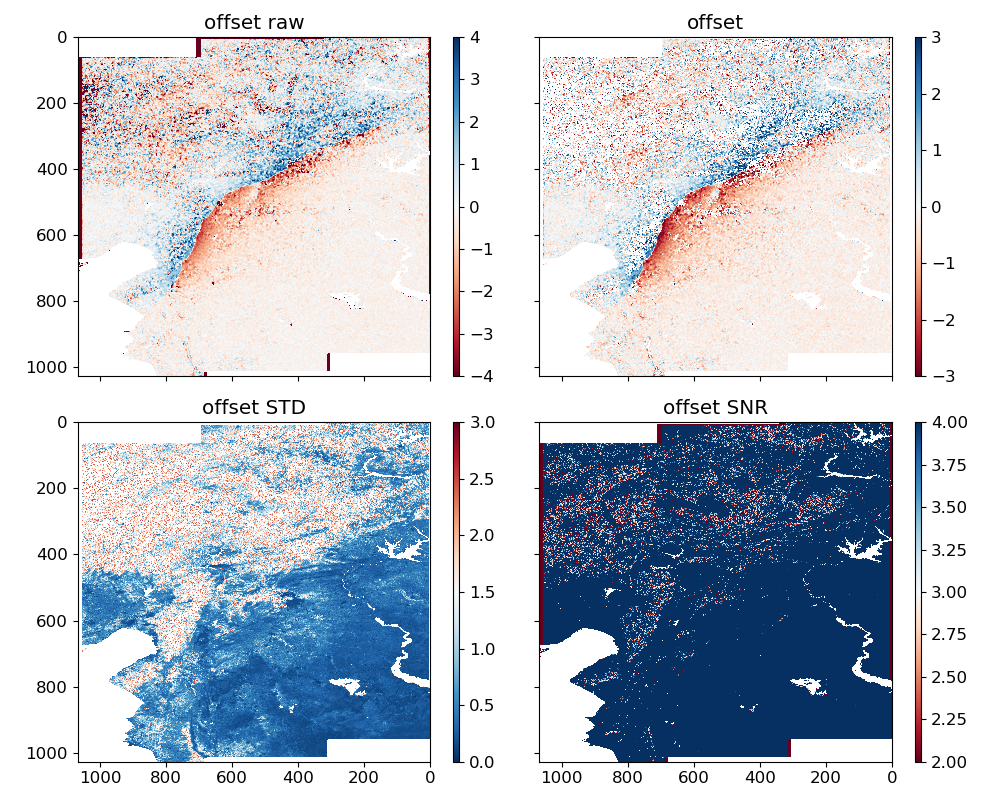

In [3]:
config = {
    'SenA014_20230128_20230209_RG': {'max_off': 5, 'min_snr': 5, 'max_std': 0.5},
    'SenA014_20230128_20230209_AZ': {'max_off': 5, 'min_snr': 3, 'max_std': 3.0},
    'SenD021_20230129_20230210_RG': {'max_off': 5, 'min_snr': 3, 'max_std': 0.5},
    'SenD021_20230129_20230210_AZ': {'max_off': 5, 'min_snr': 3, 'max_std': 3.0},
}[ds_name]

# read and mask
off, off_std, off_snr = read_offset()
off, off_std, off_snr, off_raw = mask_offset(off, off_std, off_snr, config)

# write to one HDF5 files
atr['ORBIT_DIRECTION'] = 'ASCENDING' if ds_name.startswith('SenA') else 'DESCENDING'
if redo or not os.path.isfile(rdr_file):
    ds_dict      = {'displacement' : np.array(off, dtype=np.float32), 'displacementStd' : np.array(off_std, dtype=np.float32)}
    ds_unit_dict = {'displacement' : 'm', 'displacementStd' : 'm'}
    writefile.write(ds_dict, out_file=rdr_file, metadata=atr, ds_unit_dict=ds_unit_dict, compression='lzf', print_msg=False)

# plot
%matplotlib widget
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[10, 8], sharex=True, sharey=True)
for ax, data, [vmin, vmax], cmap, title in zip(axs.flatten(), [off_raw, off, off_std, off_snr], [[-4, 4], [-3, 3], [0, config['max_std']], [2, config['min_snr']+1]], ['RdBu', 'RdBu', 'RdBu_r', 'RdBu'], ['offset raw', 'offset', 'offset STD', 'offset SNR']):
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest'); fig.colorbar(im, ax=ax, aspect=50); pp.auto_flip_direction(atr, ax, print_msg=False); ax.set_title(title)
fig.tight_layout()
plt.show()

## 2. Geocode

Step size: 0.00277778 deg (~300m)

In [3]:
if step is None:
    iw_xml_file = os.path.join(proj_dir, ds_name, 'referencedir/IW1.xml')
    meta = isce_utils.extract_isce_metadata(iw_xml_file)[0]
    meta['WIDTH'] = int(atr['WIDTH']) * 64
    ystep_m = ut.azimuth_ground_resolution(meta) * 32;  ystep_d = ystep_m / 108e3
    xstep_m = ut.range_ground_resolution(meta) * 64;    xstep_d = xstep_m / (108e3 * np.cos(np.deg2rad(37)))
    print(f'y/x step: {ystep_m:.1f} / {xstep_m:.1f} m; {ystep_d:.4f}, {xstep_d:.4f} deg')

geocode.py /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/offRg.h5 --dset displacement -o /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/offRg.geo --lat-file /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/lat.rdr.mli --lon-file /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/lon.rdr.mli --fill nan --bbox 35.3 39.0 35.0 39.5 --lalo -0.00277778 0.00277778
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/lat.rdr.mli
output pixel size in (lat, lon) in degree: (-0.00277778, 0.00277778)
output area extent in (S, N, W, E) in degree: (35.29999704, 39.0, 35.0, 39.5000036)
output file row / column number: (1332, 1620)
[1/1] preparing geometry for dest_box: (0, 0, 1620, 1332) --> full src_box: (0, 0, 1068, 1028)
---------------------

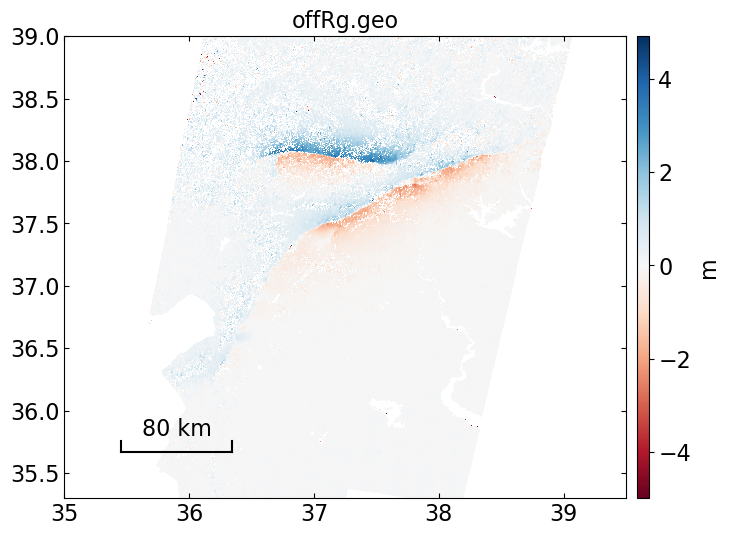

In [19]:
#opt = f' --bbox {S} {N} {W} {E} --lalo -{step} {step} --lat-file {lat_file} --lon-file {lon_file}'
opt = f'--lat-file {lat_file} --lon-file {lon_file} --fill nan --bbox {S} {N} {W} {E} --lalo -{step} {step}'
fbase = os.path.splitext(rdr_file)[0]
io_files = [
    [rdr_file, '--dset displacement',    f'{fbase}.geo'],      # offset
    [rdr_file, '--dset displacementStd', f'{fbase}Std.geo'],   # offset STD
    [los_file, '', os.path.join(work_dir, 'los.geo')]          # offset geometry
]
for ifile, dset, ofile in io_files:
    if redo or not os.path.isfile(ofile):
        cmd = f'{ifile} {dset} -o {ofile} {opt}'
        print(f'geocode.py {cmd}')
        geocode.main(cmd.split())

# plot
%matplotlib inline
view.main(f'{fbase}.geo -c RdBu --noverbose'.split())

## 3. Correct for troposphere and SET (for range offsets)

In [20]:
from mintpy.cli import load_data, smallbaselineApp
# write geometry HDF5 file
config = f"""# vim: set filetype=cfg:
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = {os.path.join(work_dir, '../referencedir/IW1.xml')}
mintpy.load.baselineDir      = None
##---------geometry datasets:
mintpy.load.demFile          = {hgt_file}
mintpy.load.lookupYFile      = {lat_file}
mintpy.load.lookupXFile      = {lon_file}
mintpy.load.incAngleFile     = {los_file}
mintpy.load.azAngleFile      = {los_file}
mintpy.load.waterMaskFile    = {msk_file}
"""
sname, oname = ds_name.split('_')[:2]
config_file = os.path.join(work_dir, f'{sname}_{oname}.txt')
print('write MintPy configuration to file: {}'.format(config_file))
with open(config_file, "w") as fid:
    fid.write(config)
smallbaselineApp.main(f'{config_file} -g'.split())
# write geometryRadar.h5
load_data.main(f'-t smallbaselineApp.cfg --geom'.split())
# write geometryGeo.h5
geocode.main(f'./inputs/geometryRadar.h5 -o ./inputs/geometryGeo.h5 {opt}'.split())

write MintPy configuration to file: /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/S1_D021.txt
--------------------------------------------------
Project name: S1_D021
Go to work directory: /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5
copy default template file /Users/yunjunz/tools/MintPy/src/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/S1_D021.txt
update default template based on input custom template
    mintpy.load.processor: auto --> isce
    mintpy.load.metaFile: auto --> /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/../referencedir/IW1.xml
    mintpy.load.baselineDir: auto --> None
    mintpy.load.demFile: auto --> /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/z.rdr.mli
    mintpy.load.lookupYFile: auto --> /Users/yunjunz/data/archives/2023T

/Users/yunjunz/tools/MintPy/src/mintpy/load_data.py:680: UserWarning: prep_isce.py failed. Assuming its result exists and continue...
  warnings.warn('prep_isce.py failed. Assuming its result exists and continue...')


nearest resampling with pyresample.kd_tree using 1 CPU cores in 3 segments ...
write data in block [0, 1332, 0, 1620] to file: ./inputs/geometryGeo.h5
--------------------------------------------------1/1
reading height             in block (0, 0, 1068, 1028) from geometryRadar.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 3 segments ...
write data in block [0, 1332, 0, 1620] to file: ./inputs/geometryGeo.h5
--------------------------------------------------1/1
reading incidenceAngle     in block (0, 0, 1068, 1028) from geometryRadar.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 3 segments ...
write data in block [0, 1332, 0, 1620] to file: ./inputs/geometryGeo.h5
--------------------------------------------------1/1
reading latitude           in block (0, 0, 1068, 1028) from geometryRadar.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 3 segments ...
write data in block [0, 1332, 0, 1620] to file: ./inputs/geomet

In [25]:
# add some metadata
meta = readfile.read_roipac_rsc(os.path.join(proj_dir, ds_name[:-3], 'referencedir/data.rsc'))
meta['DATE12'] = ptime.yymmdd_date12(ptime.get_date12_from_path(ds_name))
meta['FILE_TYPE'] = 'displacement'
ut.add_attribute('./offRg.geo', meta, print_msg=True)

All updated (removed) attributes already exists (do not exists) and have the same value, skip update.


'./offRg.geo'

In [26]:
!tropo_pyaps3.py -f ./offRg.geo -g ./inputs/geometryGeo.h5

weather model: ERA5 - dry (hydrostatic) and wet delay
weather directory: /Users/yunjunz/data/aux
output tropospheric delay     time-series file: ./inputs/ERA5.h5
output corrected displacement time-series file: ./offRg_ERA5.geo
read dates/time info from file: ./offRg.geo
time of cloest available product: 04:00 UTC

--------------------------------------------------------------------------------
Download global atmospheric model files...
update mode: ON
output file: ./inputs/ERA5.h5
1) output file exists and is newer than all GRIB files.
2) output file has the same len/wid as the geometry file and contains all dates
3) output file is fully written.
run or skip: skip
Skip downloading and use existed troposhperic delay HDF5 file: ./inputs/ERA5.h5.

--------------------------------------------------------------------------------
Calculate tropospheric delay and write to HDF5 file...
update mode: ON
output file: ./inputs/ERA5.h5
1) output file exists and is newer than all GRIB files.
2) outp

In [27]:
!solid_earth_tides.py ./offRg_ERA5.geo -g ./inputs/geometryGeo.h5

prepare LOS geometry in geo-coordinates from file: ./inputs/geometryGeo.h5
read incidenceAngle from file: ./inputs/geometryGeo.h5
read azimuthAngle   from file: ./inputs/geometryGeo.h5
get the unit vector for enu2los projection with mean value: E = 0.616, N = -0.109, U = 0.776.

--------------------------------------------------
calculating solid Earth tides using PySolid (Milbert, 2018; Yunjun et al., 2022) ...
[==================================================] 2023-02-10T03:34:21 (2/2)    0s /     0s
delete exsited file: ./inputs/SET.h5
create HDF5 file: ./inputs/SET.h5 with w mode
create dataset /timeseries of float32    in size of (2, 1332, 1620)      with compression=None
create dataset /date       of |S8        in size of (2,)                 with compression=None
create dataset /sensingMid of |S15       in size of (2,)                 with compression=None
finished writing to ./inputs/SET.h5
correcting tide for using diff.py
diff.py ./offRg_ERA5.geo ./inputs/SET.h5 -o ./offRg_

## 4. Plot

run view.py in MintPy version 1.5.1.post35, date 2023-05-23
input file is isce displacement file: /Users/yunjunz/data/archives/2023TurkeyEQ/S1_D021_20230129_20230210/offset_v5/offRg_ERA5_SET.geo in float32 format
file size in y/x: (1332, 1620)
num of datasets in file offRg_ERA5_SET.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 1620, 1332)
subset coverage in y/x: (0, 0, 1620, 1332)
data   coverage in lat/lon: (35.0, 39.0, 39.5000036, 35.29999704)
subset coverage in lat/lon: (35.0, 39.0, 39.5000036, 35.29999704)
------------------------------------------------------------------------
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: S1_D021_20230129_20230210_RG
figure size : [9.12, 6.00]
reading data ...
masking pixels with NO_DATA_VALUE of -10000.0
data    range: [-4.991801, 4.943524] m
display range: [-3.0, 3.0] m
reading DEM: demLat_N35_N42_Lon_E034_E041_90m.h5 ...
display data in transparency: 0.8
plot in 

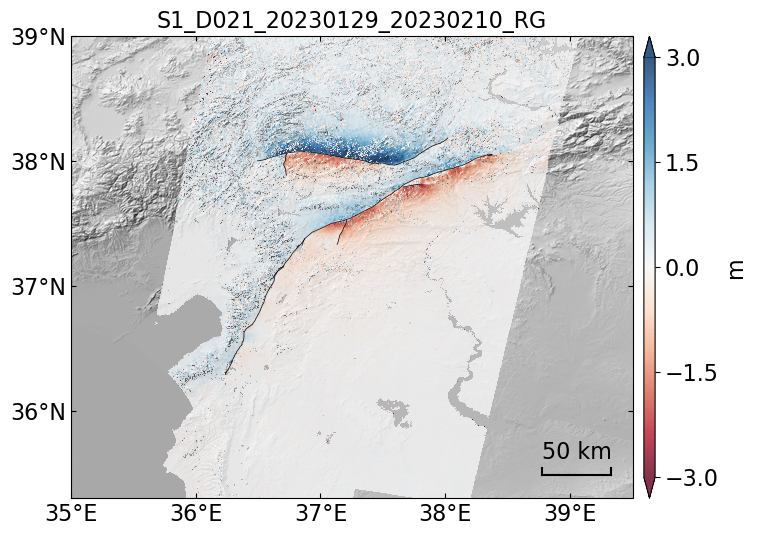

In [28]:
%matplotlib inline
dis_file = f'{fbase}.geo' if fbase.endswith('Az') else f'{fbase}_ERA5_SET.geo'
dem_file = os.path.join(proj_dir, 'DEM/demLat_N35_N42_Lon_E034_E041_90m.h5')
flt_file = os.path.join(proj_dir, 'USGS/simple_fault_confident.lonlat')
out_file = os.path.join(proj_dir, f'notebooks/docs/{ds_name}.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
cmd += f'-c RdBu -v -3 3 --lalo-label --lalo-step 1 --cbar-nbins 5 --scalebar 0.12 0.90 0.05 --title {ds_name} '
cmd += f'-o {out_file} '
view.main(cmd.split())

## 5. Aux Info

In [31]:
atr = readfile.read_attribute(rdr_file)
atr.update(isce_utils.extract_isce_metadata(xml_file, update_mode=False)[0])

rg_pix_size = ut.range_ground_resolution(atr) * 128
az_pix_size = ut.azimuth_ground_resolution(atr) * 64
print(f'Chip size on the ground: range = {rg_pix_size:.0f} m, azimuth = {az_pix_size:.0f} m')

rg_filt_size = ut.range_ground_resolution(atr) * 64 * 5
az_filt_size = ut.azimuth_ground_resolution(atr) * 32 * 5
print(f'Median filter size on the ground: range = {rg_filt_size/1000:.1f} km, azimuth = {az_filt_size/1000:.1f} km')


extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/archives/2023TurkeyEQ/SenD021_20230129_20230210/offset_v5/../referencedir/IW1.xml
Chip size on the ground: range = 585 m, azimuth = 900 m
Median filter size on the ground: range = 1.5 km, azimuth = 2.2 km
